# Sports match video to text summarization

In this project we try to summarise video to text using alexnet with transform lerning.
procedure that we follow is as below:
1. Prepare dataset from sport videos
2. Create one model and pass this preprocess dataset
3. Predict the class of input frame

In our project we follow this research paper.
link: https://www.mdpi.com/1424-8220/20/6/1702/htm

In [1]:
#This are some required libraries
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import io
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pickle

# Dataset preparation

First we fetch the dataset from folder are divide them in train set and test set.
During preprocessing we resize our images to 227x227 size. Batch size is 32.

In [2]:
"""
In this cell we open the dataset and display the sample image. Also, make one list of class lables.
"""

data_dir = pathlib.Path("../dataset")
clas = ["Batting","Boundary","Bowling","Close-up","Crowd"]
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

22987


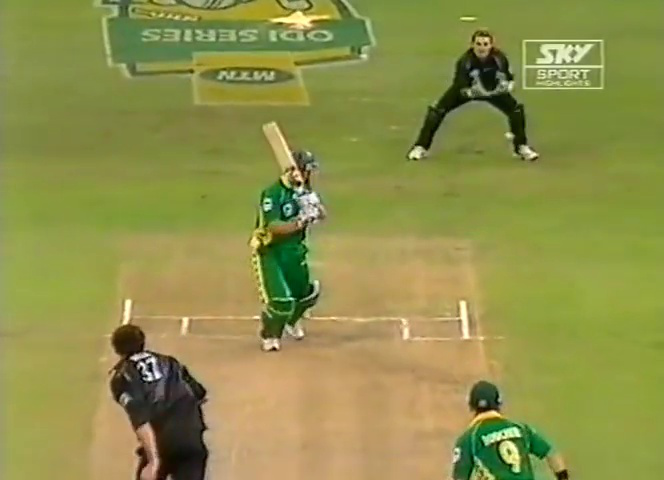

In [3]:
Bat = list(data_dir.glob('Batting/*'))
PIL.Image.open(str(Bat[1]))

In [4]:
"""
Information of dataset preprocessing.
"""
batch_size = 32
img_height = 227
img_width = 227

In [5]:
"""
Here, we divide our dataset in training set.
"""

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22987 files belonging to 5 classes.
Using 18390 files for training.
Metal device set to: Apple M1


2021-11-22 11:26:48.494313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-22 11:26:48.494456: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
"""
Here, we divide our dataset in test set.
"""

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22987 files belonging to 5 classes.
Using 4597 files for validation.


# Experiment

Here we do one experiment on the dataset. That is we augment each image. In augmentation we flip the image in horizontally or vertically. In below cell code for that but it is not running on machine due to heavy load. So, we drop this idea.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
])
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),num_parallel_calls=AUTOTUNE)
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2021-11-22 11:26:53.513731: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-22 11:26:53.513981: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


0.0 255.0


# Model Information

As per the research paper we have to use pre trainded alexnet model with imagenet. After that we have to apply the transform learning. But We want to know how alexnet work directly on this dataset. So, we created whole model from scratch. We got around 50% acc.

In [8]:
"""
For model creation we use tensorflow 2.x with keras. we follow this tutorial for this 'https://www.tensorflow.org/tutorials/images/classification'.
"""

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'),
    #keras.layers.ZeroPadding2D(padding=(1, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
    #keras.layers.ZeroPadding2D(padding=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
    #keras.layers.ZeroPadding2D(padding=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(5, activation=keras.activations.softmax)
])

# Saving the model

Due to limited resources we train our model partly.At the end of each part we store our model weights in file. Logic for that is given below.

In [9]:
"""
For checkpointing we created a callback function. 
"""
checkpoint_path = "../training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [10]:
"""
By running this you can watch out the model summary.
"""

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.05), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)      

/Users/jaiminchauhan/miniforge3/envs/env_dl/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# Traning the model

Here we train our model. At the end of 10 epoch we store our model weight in file. Also we store the model history in file.In total we execute 20 epoch and we get 50% acc.

In [12]:
cou = 0
if os.path.exists('../training'):
    model.load_weights(checkpoint_path)
history = model.fit(train_ds, epochs=10, callbacks=[cp_callback])
with open('./trainHistoryDict_'+str(cou), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Epoch 1/10


2021-11-22 11:27:14.262563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


264/575 [============>.................] - ETA: 1:33 - loss: 1.3597 - accuracy: 0.5049

KeyboardInterrupt: 

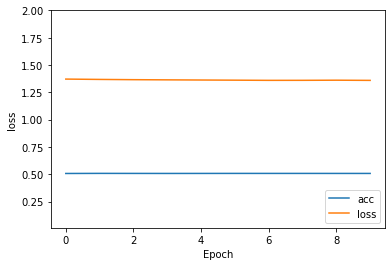

In [31]:
history = pickle.load(open('../trainHistoryDict_0', "rb"))
plt.plot(history['accuracy'], label='acc')
plt.plot(history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.01, 2])
plt.legend(loc='lower right')
cou+=1

# Testing the model

Here we test our model and get around 51% acc.

In [23]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

2021-11-22 09:38:47.253154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


144/144 - 12s - loss: 1.3513 - accuracy: 0.5099


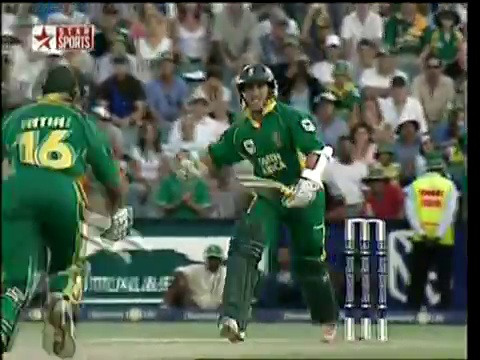

In [29]:
Clo = list(data_dir.glob('Close-up/*'))
PIL.Image.open(str(Clo[1]))

In [28]:
img_path = '../dataset/Close-up/frame2455.jpg'
img = tf.keras.utils.load_img(
    img_path, target_size=(227, 227)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(clas[np.argmax(score)], 100 * np.max(score))
)

tf.Tensor([0.18103768 0.18199003 0.17958805 0.26492074 0.19246349], shape=(5,), dtype=float32)
This image most likely belongs to Close-up with a 26.49 percent confidence.
